In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
from pathlib import Path

from config import DATA_ROOT
from config_targets import TARGET_META

from utils import import_key_data
from ecg_predict import batched_predict_all
from eval import evaluate_all_payloads, evaluate_explanation
from explainer import run_fused_pipeline_for_classes
from selection import build_selection_df_with_aliases, build_y_true_from_labels

%load_ext autoreload
%autoreload 2

In [2]:
ROOT = Path.cwd().parent

MODEL_PATH         = ROOT / "model" / "resnet_final.keras"
SNOMED_CLASSES_NPY = ROOT / "data" / "snomed_classes.npy"
SEL_DF_CSV         = ROOT / "data" / "ecg_model_pred_data.csv"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
class_names = np.load(SNOMED_CLASSES_NPY, allow_pickle=True)

In [3]:
# gender, age, labels, ecg_filenames = import_key_data(DATA_ROOT)

# # Make sure class_names matches the model's output order
# class_names = np.load("snomed_classes.npy", allow_pickle=True).astype(str)

# # 1) Build ground-truth multi-hot labels
# y_true = build_y_true_from_labels(labels, class_names)

# # 2) Predict probabilities
# probs = batched_predict_all(
#     model,
#     ecg_filenames,
#     maxlen=5000,
#     batch_size=32,
# )

# # 3) Optional: binary predictions (0/1) at some threshold
# pred_threshold = 0.5
# y_pred = (probs >= pred_threshold).astype(np.int8)

# # 4) Save everything
# np.save("ecg_filenames.npy", ecg_filenames)
# np.save("ecg_model_probs.npy", probs)
# np.save("ecg_y_true.npy", y_true)
# np.save(f"ecg_y_pred_{pred_threshold:.2f}.npy", y_pred)


In [4]:
ecg_filenames = np.load("ecg_filenames.npy", allow_pickle=True)
probs         = np.load("ecg_model_probs.npy")
class_names   = np.load("snomed_classes.npy", allow_pickle=True)
y_true        = np.load("ecg_y_true.npy")

sel_df = build_selection_df_with_aliases(
    ecg_filenames=ecg_filenames,
    probs=probs,
    class_names=class_names,
    target_meta=TARGET_META,
    y_true=y_true,
    k_per_class=3,
    min_prob=0.85,
    max_duration_sec=20.0,
    duration_cache_path="ecg_durations.npy"
)

sel_df.to_csv("ecg_xai_sel_meta_p0.85_k5.csv", index=False)
sel_df


[INFO] Estimating durations and keeping ECGs <= 20.0 s...
[INFO] Duration filter: keeping 40665/43101 ECGs (<= 20.0 s).
[CLASS 164889003 (atrial fibrillation)] picked 3 examples.


,group_class,filename,sel_idx,duration_sec,prob_meta
0,164889003,C:\data\ptbxl-electrocardiography-database\WFD...,28470,10.0,0.997502
1,164889003,C:\data\china-physiological-signal-challenge-i...,4342,10.0,0.991137
2,164889003,C:\data\ptbxl-electrocardiography-database\WFD...,34405,10.0,0.997415


In [5]:
target_classes = list(TARGET_META.keys())   # ["164889003", "426783006", "17338001"]

print("Target classes:", target_classes)

all_fused_payloads, df_lime_all, df_ts_all = run_fused_pipeline_for_classes(
    target_classes=target_classes,
    sel_df=sel_df,
    model=model,
    class_names=class_names,
    max_examples_per_class=5,
    plot=False,
)

Target classes: ['164889003']


In [6]:
df_eval_all = evaluate_all_payloads(
    all_payloads=all_fused_payloads,
    method_label="LIME+TimeSHAP",
    debug=False,
    model=model,
    class_names=class_names,
)

df_eval_all

,meta_code,class_name,sel_idx,mat_path,method,strict_attauc,lenient_attauc,strict_f1,lenient_f1,deletion_auc,n_tokens
0,164889003,atrial fibrillation,4342,C:\data\china-physiological-signal-challenge-i...,LIME+TimeSHAP,0.918512,0.652303,0.645161,0.8,0.275050,204
1,164889003,atrial fibrillation,28470,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.860947,0.579604,0.571429,0.8,0.291384,156
2,164889003,atrial fibrillation,34405,C:\data\ptbxl-electrocardiography-database\WFD...,LIME+TimeSHAP,0.889497,0.607156,0.581818,0.8,0.292816,156


In [8]:
import pandas as pd

# Group by SNOMED meta-code + human-readable name
summary = (
    df_eval_all
    .groupby(["meta_code", "class_name"])
    .agg(
        # --- AttAUC: ranking-based localisation accuracy ---
        strict_attauc_mean=("strict_attauc", "mean"),
        strict_attauc_std=("strict_attauc", "std"),
        lenient_attauc_mean=("lenient_attauc", "mean"),
        lenient_attauc_std=("lenient_attauc", "std"),

        # --- F1: threshold-based localisation accuracy ---
        strict_f1_mean=("strict_f1", "mean"),
        strict_f1_std=("strict_f1", "std"),
        lenient_f1_mean=("lenient_f1", "mean"),
        lenient_f1_std=("lenient_f1", "std"),

        # --- Deletion AUC: faithfulness (lower is better) ---
        deletion_auc_mean=("deletion_auc", "mean"),
        deletion_auc_std=("deletion_auc", "std"),

        # Token count (just descriptive)
        n_tokens_mean=("n_tokens", "mean"),
        n_tokens_std=("n_tokens", "std"),
    )
    .reset_index()
)

summary
# Optionally save for the thesis
summary.to_csv("xai_metric_summary_per_class.csv", index=False)


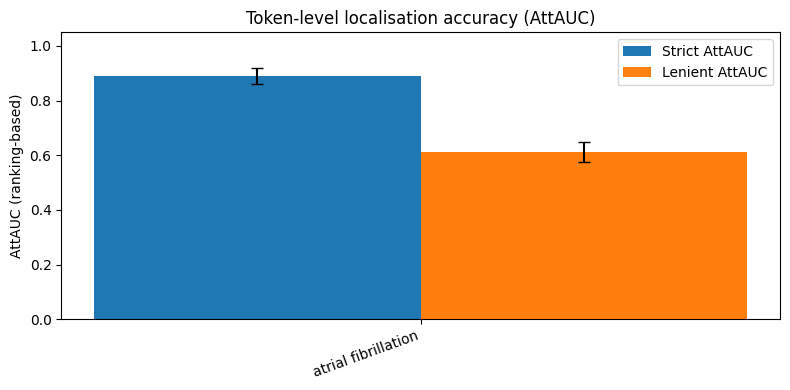

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# For nicer x-axis labels
classes = summary["class_name"].values
x = np.arange(len(classes))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 4))

# Strict AttAUC: explainer vs strict, narrow definition of "correct"
ax.bar(
    x - width/2,
    summary["strict_attauc_mean"],
    width,
    yerr=summary["strict_attauc_std"],
    capsize=4,
    label="Strict AttAUC",
)

# Lenient AttAUC: explainer vs broader, more forgiving ground truth
ax.bar(
    x + width/2,
    summary["lenient_attauc_mean"],
    width,
    yerr=summary["lenient_attauc_std"],
    capsize=4,
    label="Lenient AttAUC",
)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_ylabel("AttAUC (ranking-based)")
ax.set_ylim(0, 1.05)
ax.set_title("Token-level localisation accuracy (AttAUC)")
ax.legend()
plt.tight_layout()
plt.show()


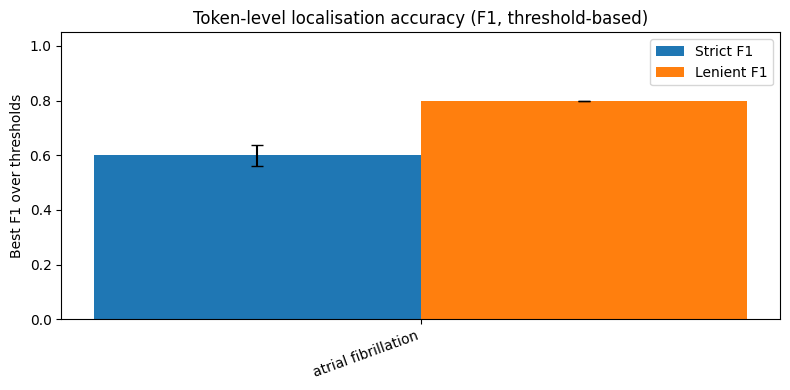

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(
    x - width/2,
    summary["strict_f1_mean"],
    width,
    yerr=summary["strict_f1_std"],
    capsize=4,
    label="Strict F1",
)

ax.bar(
    x + width/2,
    summary["lenient_f1_mean"],
    width,
    yerr=summary["lenient_f1_std"],
    capsize=4,
    label="Lenient F1",
)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_ylabel("Best F1 over thresholds")
ax.set_ylim(0, 1.05)
ax.set_title("Token-level localisation accuracy (F1, threshold-based)")
ax.legend()
plt.tight_layout()
plt.show()


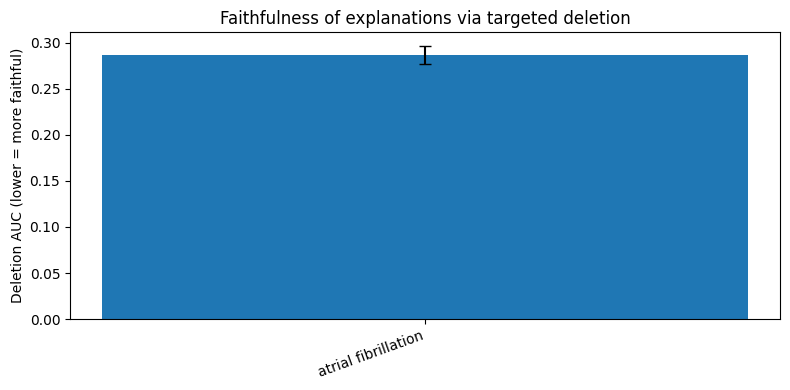

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

# Lower deletion AUC => more faithful (probability drops faster)
ax.bar(
    x,
    summary["deletion_auc_mean"],
    yerr=summary["deletion_auc_std"],
    capsize=4,
)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=20, ha="right")
ax.set_ylabel("Deletion AUC (lower = more faithful)")
ax.set_title("Faithfulness of explanations via targeted deletion")
plt.tight_layout()
plt.show()


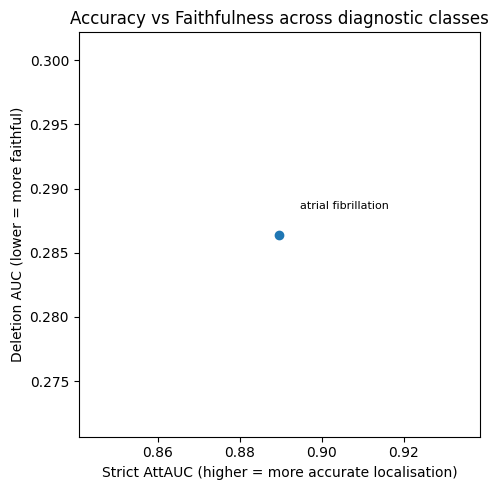

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

# Use strict AttAUC on x-axis and deletion AUC on y-axis
ax.scatter(
    summary["strict_attauc_mean"],
    summary["deletion_auc_mean"],
)

for _, row in summary.iterrows():
    ax.text(
        row["strict_attauc_mean"] + 0.005,
        row["deletion_auc_mean"] + 0.002,
        row["class_name"],
        fontsize=8,
    )

ax.set_xlabel("Strict AttAUC (higher = more accurate localisation)")
ax.set_ylabel("Deletion AUC (lower = more faithful)")
ax.set_title("Accuracy vs Faithfulness across diagnostic classes")
plt.tight_layout()
plt.show()
